# Mean Variance Optimization
Using proxies for various asset classes, we will use Monte Carlo Simulation to conduct the Portfolio Optimiziation method called Mean-Variance in order to determine the minimum risk and maximum Sharpe ratio portfolios. 

We are fixing our scope to US investments only where applicable.

`SPY`: Equity<br>
`BND`: Bond<br>
`GLD`: Commodity (gold)<br>
`USRT`: Real Estate (REIT)<br>

## Background
This type of optimization is based on Harry Markowitz's famous 1952 thesis that an investor wants to maximize their return for a given measure of risk. Portfolios that fit this constraint lie on what's called the efficient frontier. The **efficient frontier** can be calculated emprically by simulation (which we do here), but it can also by calculation by setting it up as a optimization problem. Portfolio optimization is useful to the extent that **diversification** works. Diversification is based on the idea that stock volatility is not wholly additive: stocks with negative correlation/covariance can reduce the total risk of a porfolio. 

## Programming Note
Since this is meant to be an illustrative notebook and very little if any code is replicated, we will not use any user-defined functions or classes outside of lambda. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')

tks = ['SPY', 'GLD', 'USRT', 'BND']
hold = []
for tk in tks:
    df = pd.read_csv(r'data/{}.csv'.format(tk))  # source is Yahoo
    df['Ticker'] = tk
    df['Date'] = pd.to_datetime(df['Date'])
    hold.append(df)
    
agg_tks = pd.concat(hold).sort_values(by='Ticker', ascending=True)
agg_tks.reset_index(inplace=True, drop=True)

In [2]:
prices = agg_tks.pivot(index=['Date'], columns=['Ticker'], values=['Adj Close'])
assert not np.any(prices.isnull().values)

In [3]:
pp = prices.pct_change().copy()
pp.tail()

Adj Close                              
Ticker           BND       GLD       SPY      USRT
Date                                              
2020-12-24  0.001707  0.003985  0.003890  0.007593
2020-12-28 -0.000341 -0.003629  0.008591  0.008373
2020-12-29  0.000341  0.003642 -0.001908 -0.009342
2020-12-30  0.000682  0.007655  0.001427  0.004401
2020-12-31  0.001363  0.003714  0.005081  0.010015

### Defintions
Portfolio Expected Return: mean of ex-post annual returns over 5 year period<br>
Portfolio Risk/Volatility: standard deviation of ex-post daily returns over a 5 year period, annualized
Portfolio Sharpe Ratio: risk adjusted expected return normalized by risk

### Nota bene
There are some obvious considerations that would need to be addressed to use something like this in practice:

- Returns (Adj Close) are not total return figures, only price returns (excludes dividends.) If we are agnostic to income versus capital gains, these returns are incomplete. For this exercise, we will use ex-post returns. 
- Since returns of past do not predict the future, really we should be using forecasted (ex-ante) returns.
- For meaningful portfolio optimization, selecting a time period such that it represents all the variation in prices is critical. Even if historical returns were deemed a legitimate proxy for future returns, we would need to capture a lot more variation than can be covered in 5 year. 
- It may be best to use index values as proxies for asset classes
- Typically once we've optimized the asset classes, we should also optimize for the stock hold within each asset class
- We are assuming no liquidity constraints which may be prevalent in deeper bond portfolios
- We are assuming we never need to re-optimize the portfolio. In practice, the optimal weights changes frequently over time and those that change more are subject to transaction fees, reducing the performance
- When doing asset class optimization, we are assuming the constituents are mutually exclusive. This may not be the case for SPY and USRT since SPY holds some REITs (ie. American Tower Corp, AMT)

In [4]:
c = pp.cov()
c

Adj Close                              
Ticker                 BND       GLD       SPY      USRT
          Ticker                                        
Adj Close BND     0.000010  0.000009  0.000002  0.000010
          GLD     0.000009  0.000077 -0.000002  0.000008
          SPY     0.000002 -0.000002  0.000141  0.000130
          USRT    0.000010  0.000008  0.000130  0.000220

In [5]:
ers = prices.resample('Y').last().pct_change().mean().loc['Adj Close']

NUM_TRADING_DAYS = 252
vols = pp.var().apply(lambda x: np.sqrt(x* NUM_TRADING_DAYS)).loc['Adj Close']  # just for display

rr = pd.concat([ers, vols], axis=1)
rr.columns = ['Expected Return', 'Volatility']
rr

,Expected Return,Volatility
Ticker,,
BND,0.046372,0.049465
GLD,0.123142,0.139278
SPY,0.157380,0.188651
USRT,0.051367,0.235422


### Formulae

$$w = \begin{bmatrix} w_1 \\ \vdots \\ w_n \end{bmatrix}
\ r = \begin{bmatrix} r_1 \\ \vdots \\ r_n \end{bmatrix}
\ C = \begin{bmatrix}
    \sigma_{1, 1} & \ldots & \sigma_{1, n} \\
    \vdots   & \ddots & \vdots   \\
    \sigma_{n, 1} & \ldots & \sigma_{n, n}
\end{bmatrix} $$
<br>

**<center>Portfolio Expected Return</center>**<br>

$$\mu_p = w^T r$$
$$= \sum_{i=1}^n w_i r_i$$<br>

**<center>Portfolio Variance</center>**<br>

$$\sigma_p^2 = w^T C w$$<br>
$$ = w_1^2 \sigma_1^2 + ... w_n^2 \sigma_n^2 + 2 w_1 w_ 2\sigma_{1,2}^2 + ... 2 w_{n-1} w_n \sigma_{n-1, n}^2$$
$$ = \sum_{i=1}^n w_i^2 \sigma_{i,i} + 2 \sum_{i \ne j \& i < j}    w_i w_ j\sigma_{i,j}^2$$<br> Note: in the last summation, i and j represent the index values needed to list out all combinations of ${n \choose 2}$

## Monte Carlo Simulation

As of 1/20/2021, the US 3-month Treasury is offering $0.08\%$ while the 1-year is $0.10\%$. We will assume we are not rebalancing intra-year so the 1-year rate should suffice. For context, these rates are historically low.

In [6]:
np.random.seed(69)
N = int(1e4)
ws = np.random.random((N, len(tks)))  # initialize 10,000 random weights for each of the n tickers
ws = (ws.T / ws.sum(axis=1)).T  # normalize weights to sum to 1
RISK_FREE = 0.001

prets = []
pvols = []
psharpes = []

for w in ws:
    w = w.reshape(-1, 1)
    pret = np.dot(rr.iloc[:, 0].values, w).sum()
    prets.append(pret)
    
    pvol = np.sqrt(np.dot(w.T, np.dot(c.values, w)).sum().sum())
    pvol_ann = pvol * np.sqrt(NUM_TRADING_DAYS)
    pvols.append(pvol_ann)
    
    psharpe = (pret - RISK_FREE)/pvol_ann
    psharpes.append(psharpe)
    

In [7]:
matrix = np.concatenate([np.array(prets).reshape(-1, 1)
                         ,np.array(pvols).reshape(-1, 1) 
                         ,np.array(psharpes).reshape(-1, 1)
                         ,ws], axis=1)
sim_results = pd.DataFrame(matrix, columns=['Portfolio Expected Return', 
                                            'Portfolio Volatility/Risk', 
                                            'Portfolio Expected Sharpe Ratio'] + sorted(tks))
sim_results.head()

,Portfolio Expected Return,Portfolio Volatility/Risk,Portfolio Expected Sharpe Ratio,BND,GLD,SPY,USRT
0,0.093115,0.121758,0.756540,0.131961,0.360390,0.156016,0.351633
1,0.078479,0.064177,1.207270,0.573756,0.259194,0.107297,0.059753
2,0.094388,0.114237,0.817494,0.232830,0.241315,0.253402,0.272453
3,0.120361,0.143267,0.833139,0.052185,0.217058,0.506311,0.224447
4,0.082805,0.116942,0.699534,0.328855,0.126665,0.226284,0.318196


Find the minimum volatility and max sharpe ratio portfolio

In [8]:
min_risk_idx = np.argmin(pvols)
max_sharpe_idx = np.argmax(psharpes)

Plot

In [9]:
sim_results.iloc[:, 2].max()

1.3437471368571998

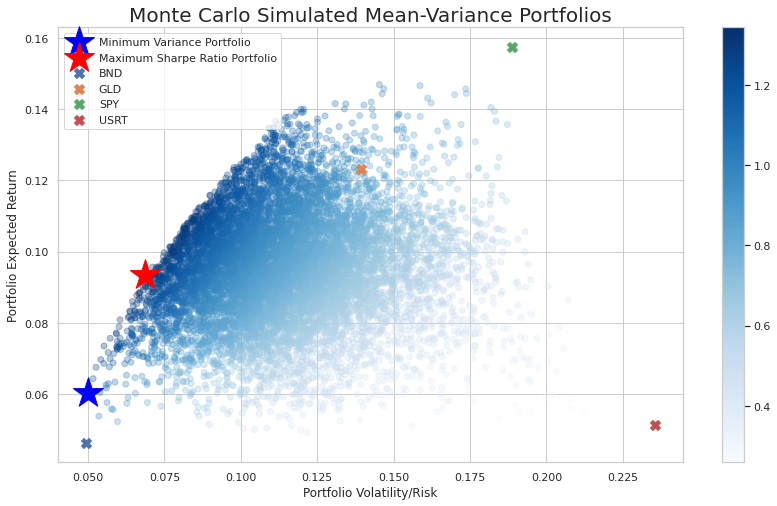

In [10]:
plt.figure(figsize=(14,8))
plt.title('Monte Carlo Simulated Mean-Variance Portfolios', fontsize=20)
plt.scatter(sim_results['Portfolio Volatility/Risk'], sim_results['Portfolio Expected Return'], 
            c=sim_results['Portfolio Expected Sharpe Ratio'], cmap='Blues', alpha=0.3)
plt.scatter(sim_results['Portfolio Volatility/Risk'].iloc[min_risk_idx], 
            sim_results['Portfolio Expected Return'].iloc[min_risk_idx], 
            s=1000, marker='*', c='blue', label='Minimum Variance Portfolio')
plt.scatter(sim_results['Portfolio Volatility/Risk'].iloc[max_sharpe_idx], 
            sim_results['Portfolio Expected Return'].iloc[max_sharpe_idx], 
            s=1000, marker='*', c='red', label='Maximum Sharpe Ratio Portfolio')
for i in range(len(rr)):
    plt.scatter(rr['Volatility'].iloc[i], rr['Expected Return'].iloc[i], marker='X', s=100, label=rr.index[i])
norm = matplotlib.colors.Normalize(vmin=sim_results.iloc[:, 2].min(), vmax=sim_results.iloc[:, 2].max())
sm = plt.cm.ScalarMappable(cmap='Blues', norm=norm)
plt.colorbar(sm)
plt.xlabel(sim_results.columns[1])
plt.ylabel(sim_results.columns[0])
plt.legend()
plt.show()

The above plot shows the where each portfolio sits on the risk (x axis)/return (y axis) curve

- Those shaded darker blue have higher Sharpe ratios
- The stars show the minimum variance and maximum Sharpe ratio portfolios
- The X's show each individual asset class on the same curve
- The colormap bar to the right shows the range of Sharpe ratio values
- If we were to draw an efficient frontier from the simulated data, it would be a line that shaded the left-most (lowest volatility) points at each subinterval along the y axis. That is the lowest risk for each return
- The Capital Allocation Line (CAL) would be the line drawn between the risk free rate and the maximum Sharpe ratio Portfolio (red star)
  - CAL is designed to allow the investor to choose their optimal compromise between the risky (invested in the above optimal asset allocations) and risk free assets
  - The CAL is useful for making various investment decisions such as when to invest in a particular stock

In [11]:
sim_results.iloc[min_risk_idx]

Portfolio Expected Return          0.060173
Portfolio Volatility/Risk          0.049854
Portfolio Expected Sharpe Ratio    1.186920
BND                                0.844413
GLD                                0.081653
SPY                                0.067575
USRT                               0.006359
Name: 7112, dtype: float64

In [12]:
sim_results.iloc[max_sharpe_idx]

Portfolio Expected Return          0.093320
Portfolio Volatility/Risk          0.068703
Portfolio Expected Sharpe Ratio    1.343747
BND                                0.489233
GLD                                0.279612
SPY                                0.229475
USRT                               0.001680
Name: 6569, dtype: float64

# Observations
- In the maximum Sharpe portfolio, $49\%$ was allocated to bonds, $28\%$ to commodities, $23\%$ to equities, and $<1\%$ to Real Estate (REITs)
  - For longer term investment horizons (ie. 10 years or more), this over-allocates to bonds and commodities while under-allocating to stocks
  - The under-allocation to stocks is likely due to the pandemic which saw unprecedented volatility in stocks in mid-2020 before recovering
  - The ordering roughly matches the performance of a [Portfolio Optimization App](https://www.portfoliovisualizer.com/optimize-portfolio#analysisResults) which allocated the most to bonds, similar amounts to stocks and commodities, and nearly nothing to Real Estate
- `BND` has slightly lower volatility than the MVP (minimum variance portfolio)
  - This is due to the fact that the Monte Carlo simulation probably didn't assign a sufficiently low weight, still it makes sense that `BND` has a dominant weighting ($84\%$) in the MVP
- `USRT` received very little allocation in either optimal portfolio
  - This is likely due to its sub-optimal risk/return ratio and high volatility

# Future Work
In the above, we are just solving this problem empirically. However the below link contains details on how to actually set this up as a proper optimization (ML) problem (see slide 10.) 

https://www.math.ust.hk/~maykwok/courses/ma362/Topic2.pdf

Despite massive volatility, Bitcoin has recently gained favor again, recovering from the massive December 2017 correct. Inspired by Ark's latest paper in Bitcoin, it would be interesting to include BTC as an asset class to see if it has material weight in an optimal portfolio.

https://ark-invest.com/white-papers/bitcoin-part-two/ (see pages 21-24)

*Work informed by: https://www.machinelearningplus.com/machine-learning/portfolio-optimization-python-example/*